In [30]:
import matplotlib.pyplot as plt

In [31]:
from scipy.optimize import fminbound, nnls, minimize_scalar
from scipy.signal import dlsim, dlti

## Functions required for the code

__Nested Key Finding Function__

In [32]:
def nest_key(d, indent=0):
    
    for key, value in d.items():
        
        print('\t' * indent + f'{key}')
        
        if isinstance(value, dict):
            
            nest_key(value, indent+1)

__Interpolation Function__

In [33]:
from scipy.interpolate import interp1d

In [34]:
def interp_ocv(z,OCV):
    
    dum = interp1d(z,OCV)
    
    return dum

__OCV calculation for any SOC value Function__

In [35]:
def OCV_from_SOC(data,OCV_0,OCV_rel,temp,eta,Q):

    etaik = data['S1']['current']

    # Negative current tends to increase the SOC thus it is charging current
    etaik[etaik < 0] = eta*etaik[etaik < 0]

    z = 1 - np.cumsum(etaik)*1/(Q*3600)  

    # OCV calculation from the given SOC (Coloumb Counting)

    OCV_0_z = interp_ocv(SOC,OCV_0)(z)
    OCV_rel_z = interp_ocv(SOC,OCV_rel)(z)

    tmp = int(temp[-2:])

    if (temp[-3] == 'N'):

        tmp = -tmp

    tmp

    ocv_z = OCV_0_z + tmp*OCV_rel_z

    return (ocv_z,z)

__State Space Matrix Identification Function__

In [36]:
def SISOsubid(y, u, n):
    """
    Identify state-space "A" matrix from input-output data.
    y: vector of measured outputs
    u: vector of measured inputs
    n: number of poles in solution
    A: discrete-time state-space state-transition matrix.

    Theory from "Subspace Identification for Linear Systems Theory - Implementation
    - Applications" Peter Van Overschee / Bart De Moor (VODM) Kluwer Academic
      Publishers, 1996. Combined algorithm: Figure 4.8 page 131 (robust). Robust
      implementation: Figure 6.1 page 169.

    Code adapted from "subid.m" in "Subspace Identification for Linear Systems"
    toolbox on MATLAB CENTRAL file exchange, originally by Peter Van Overschee,
    Dec. 1995
    """
    
    ny = len(y)
    i = 2*n
    twoi = 4*n

    # Determine the number of columns in the Hankel matrices
    j = ny - twoi + 1

    # Make Hankel matrices Y and U
    Y = np.zeros((twoi, j))
    U = np.zeros((twoi, j))

    for k in range(2*i):
        Y[k] = y[k:k+j]
        U[k] = u[k:k+j]

    # Compute the R factor
    UY = np.concatenate((U, Y))     # combine U and Y into one array
    _, r = np.linalg.qr(UY.T)       # QR decomposition
    R = r.T                         # transpose of upper triangle

    # STEP 1: Calculate oblique and orthogonal projections
    # ------------------------------------------------------------------

    Rf = R[-i:]                                 # future outputs
    Rp = np.concatenate((R[:i], R[2*i:3*i]))    # past inputs and outputs
    Ru = R[i:twoi, :twoi]                       # future inputs

    RfRu = np.linalg.lstsq(Ru.T, Rf[:, :twoi].T, rcond=None)[0].T
    RfRuRu = RfRu.dot(Ru)
    tm1 = Rf[:, :twoi] - RfRuRu
    tm2 = Rf[:, twoi:4*i]
    Rfp = np.concatenate((tm1, tm2), axis=1)    # perpendicular future outputs

    RpRu = np.linalg.lstsq(Ru.T, Rp[:, :twoi].T, rcond=None)[0].T
    RpRuRu = RpRu.dot(Ru)
    tm3 = Rp[:, :twoi] - RpRuRu
    tm4 = Rp[:, twoi:4*i]
    Rpp = np.concatenate((tm3, tm4), axis=1)    # perpendicular past inputs and outputs

    # The oblique projection is computed as (6.1) in VODM, page 166.
    # obl/Ufp = Yf/Ufp * pinv(Wp/Ufp) * (Wp/Ufp)
    # The extra projection on Ufp (Uf perpendicular) tends to give
    # better numerical conditioning (see algo on VODM page 131)

    # Funny rank check (SVD takes too long)
    # This check is needed to avoid rank deficiency warnings

    nmRpp = np.linalg.norm(Rpp[:, 3*i-3:-i], ord='fro')
    if nmRpp < 1e-10:
        # oblique projection as (Rfp*pinv(Rpp')') * Rp
        Ob = Rfp.dot(np.linalg.pinv(Rpp.T).T).dot(Rp)
    else:
        # oblique projection as (Rfp/Rpp) * Rp
        Ob = (np.linalg.lstsq(Rpp.T, Rfp.T, rcond=None)[0].T).dot(Rp)

    # STEP 2: Compute weighted oblique projection and its SVD
    #         Extra projection of Ob on Uf perpendicular
    # ------------------------------------------------------------------

    ObRu = np.linalg.lstsq(Ru.T, Ob[:, :twoi].T, rcond=None)[0].T
    ObRuRu = ObRu.dot(Ru)
    tm5 = Ob[:, :twoi] - ObRuRu
    tm6 = Ob[:, twoi:4*i]
    WOW = np.concatenate((tm5, tm6), axis=1)

    U, S, _ = np.linalg.svd(WOW, full_matrices=False)
    ss = S       # In np.linalg.svd S is already the diagonal, generally ss = diag(S)

    # STEP 3: Partitioning U into U1 and U2 (the latter is not used)
    # ------------------------------------------------------------------

    U1 = U[:, :n]       # determine U1

    # STEP 4: Determine gam = Gamma(i) and gamm = Gamma(i-1)
    # ------------------------------------------------------------------

    gam = U1 @ np.diag(np.sqrt(ss[:n]))
    gamm = gam[0:(i-1),:]
    gam_inv = np.linalg.pinv(gam)               # pseudo inverse of gam
    gamm_inv = np.linalg.pinv(gamm)             # pseudo inverse of gamm

    # STEP 5: Determine A matrix (also C, which is not used)
    # ------------------------------------------------------------------

    tm7 = np.concatenate((gam_inv @ R[3*i:4*i, 0:3*i], np.zeros((n,1))), axis=1)
    tm8 = R[i:twoi, 0:3*i+1]
    Rhs = np.vstack((tm7, tm8))
    tm9 = gamm_inv @ R[3*i+1:4*i, 0:3*i+1]
    tm10 = R[3*i:3*i+1, 0:3*i+1]
    Lhs = np.vstack((tm9, tm10))
    sol = np.linalg.lstsq(Rhs.T, Lhs.T, rcond=None)[0].T    # solve least squares for [A; C]
    A = sol[0:n, 0:n]                           # extract A

    return A

## Main Code

__File Input__

In [37]:
d = pd.read_pickle('A123_OCV_Dynamic.pkl')
stat_model = pd.read_pickle('Static Model.pkl')

In [38]:
nest_key(d)

10_N25
	S1
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
10_N15
	S1
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
30_N05
	S1
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
45_P05
	S1
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
45_P15
	S1
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step
		current

In [39]:
mag_list = list(d.keys())
script_list = list(d[mag_list[0]].keys())

In [40]:
mag_list

['10_N25',
 '10_N15',
 '30_N05',
 '45_P05',
 '45_P15',
 '50_P25',
 '50_P35',
 '50_P45']

__Model Input Variables__

In [41]:
stat_model.keys()

dict_keys(['OCV_0', 'OCV_rel', 'SOC', 'v', 'SOC_0', 'SOC_rel'])

In [42]:
# Static model parameters

SOC = stat_model['SOC']
OCV_0 = stat_model['OCV_0'] 
OCV_rel = stat_model['OCV_rel']


data_25 = d['50_P25']
total_dis_cap = 0
total_chg_cap = 0
out_d = {}

___Calculations at 25°C___

In [43]:
# Total Discharge Capacity

for i in script_list:
    
    total_dis_cap = total_dis_cap + np.array(data_25[i]['discharge_cap'])[-1]
    
# total Charging Capacity

for i in script_list:
    
    total_chg_cap = total_chg_cap + np.array(data_25[i]['charge_cap'])[-1]

# Coloumb efficiency calculation

eta25 = total_dis_cap/total_chg_cap

# Adjusting the charge capacity 

for i in script_list:
    
    data_25[i]['charge_cap'] = eta25*data_25[i]['charge_cap']
    
# Total battery capacity 
# Should be same at all the temperatures if battery degradation is not present

Q = (np.array(data_25['S1']['discharge_cap'])[-1] + \
    np.array(data_25['S2']['discharge_cap'])[-1] - \
    np.array(data_25['S1']['charge_cap'])[-1] - \
    np.array(data_25['S2']['charge_cap'])[-1])

# OCV calculation for test SOC

(ocv_z,z) = OCV_from_SOC(data_25,OCV_0,OCV_rel,'50_P25',eta25,Q)

# Storing the data in the dictionary

out_d['50_P25'] = {}
out_d['50_P25']['eta'] = eta25
out_d['50_P25']['Q']  = Q
out_d['50_P25']['ocv'] = ocv_z
out_d['50_P25']['soc'] = z

___Calculation at any temperature___

In [44]:
temp_list = mag_list
temp_list.remove('50_P25')

In [45]:
temp_list

['10_N25', '10_N15', '30_N05', '45_P05', '45_P15', '50_P35', '50_P45']

In [46]:
for temp in temp_list:

    data = d[temp]
    total_dis_cap = 0
    total_chg_cap = 0


    data['S2']['charge_cap'] = eta25*data['S2']['charge_cap']
    data['S3']['charge_cap'] = eta25*data['S3']['charge_cap']

    # Total Discharge Capacity

    for i in script_list:

        total_dis_cap = total_dis_cap + np.array(data[i]['discharge_cap'])[-1]

    total_dis_cap = total_dis_cap - np.array(data['S2']['charge_cap'])[-1] - np.array(data['S3']['charge_cap'])[-1]

    # total Charging Capacity

    for i in script_list:

        total_chg_cap = total_chg_cap + np.array(data[i]['charge_cap'])[-1]

    total_chg_cap = total_chg_cap - np.array(data['S2']['charge_cap'])[-1] - np.array(data['S3']['charge_cap'])[-1]

    # Coloumb efficiency calculation

    eta = total_dis_cap/total_chg_cap

    # Adjusting the charge capacity 

    for i in ['S1','S3']:

        data[i]['charge_cap'] = eta*data[i]['charge_cap']

    Q = (np.array(data['S1']['discharge_cap'])[-1] + \
           np.array(data['S2']['discharge_cap'])[-1] - \
           np.array(data['S1']['charge_cap'])[-1] - \
           np.array(data['S2']['charge_cap'])[-1])
    
    
    # OCV calculation for test SOC

    (ocv_z,z) = OCV_from_SOC(data,OCV_0,OCV_rel,temp,eta,Q)
    
    # Storing the data in the dictionary

    out_d[temp] = {}
    out_d[temp]['eta'] = eta
    out_d[temp]['Q']  = Q
    out_d[temp]['ocv'] = ocv_z
    out_d[temp]['soc'] = z
    

## State Space Identification

### Battery Interal Resistance = $R_{0}$
Internal resistance of the battery varies with temperature.

### Diffusion Constant
Diffusion is modeled with R-C pair. The diffusion contant for each pair is given by $F_{j}$

$$F_{j} = exp\left [ -\frac{\Delta t}{R_{j}C_{j}} \right ]$$
<br>

### Current in each element of ESC

$$i_{R}[k+1] = \begin{bmatrix}F_{1} & 0 & .. & 0\\ 0 & F_{2}  & .. & 0\\ ..& .. & .. & ..\\ 0& 0 & 0 & F_{n}\end{bmatrix} i_{R}[k]+\begin{bmatrix}1-F_{1}\\ 1-F_{2}\\ ..\\ 1-F_{n}\end{bmatrix} i[k]$$

$$ i_{R}[k+1] = A_{RC}i_{R}[k] + B_{RC}i[k]$$

$i[k]$ = Battery Current <br>
$i_{R}[k]$ = Current across diffusion resistor<br>

### Hysterisis Voltage

Hysterisis causes diversion from the OCV. After cutting the charge, the rest voltage will be larger than the OCV. After stopping the discharge, rest voltage will be lower than the discharge.

___1.Change due to SOC change___

$$A_{H}[k]=exp\left ( -\left | \frac{\eta[k]i[k]\gamma\Delta t}{Q} \right | \right )$$

$$h[k+1] = A_{H}[k]h[k]-(1-A_{H}[k])\cdot sgn(i[k])$$

___2.Change due to sign change___

Change in the sign of the current can also contribute to the hysterisis

$$s[k] = \left\{\begin{matrix} sgn(i[k]); & \left |i[k]>0\right |\\ s[k-1];& Otherwise\end{matrix}\right.$$

___Total Hysterisis___

$$hyst = M_{0}s[k]+Mh[k]$$

### State Equation

$$ \begin{bmatrix}z[k+1]\\ i_{R}[k+1]\\ h[k+1]\end{bmatrix} = \begin{bmatrix}1 & 0 & 0 \\ 0 & A_{RC} & 0\\ 0 & 0 & A_{h}[k]\end{bmatrix} \begin{bmatrix}z[k]\\ i_{R}[k]\\ h[k]\end{bmatrix} + \begin{bmatrix} -\frac{\eta[k]\Delta t}{Q} & 0\\ B_{RC} & 0\\ 0 & [A_{H}[k] - 1]\end{bmatrix}\begin{bmatrix}i[k]\\ sgn(i[k])\end{bmatrix} $$

### Output

We will try to find the pseudo inverse for obtaining the values of unknown parameters of the model. $(M,M_{0},R_{0},R_{j})$

$$v[k] = OCV[z[k],T[k]] + M_{0}s[k] + Mh[k] -\sum_{j}^{n}R_{j}i_{R_{j}}[k] - i[k]R_{0}$$
$$\tilde{v}[k] = v[k] - OCV[z[k],T[k]] = M_{0}s[k] + Mh[k] -\sum_{j}^{n}R_{j}i_{R_{j}}[k] - i[k]R_{0}$$
$$\tilde{v}[k] = \begin{bmatrix}h[k] & s[k] & -i[k] & -i_{R_{j}[k]}\end{bmatrix} \begin{bmatrix}M & M_{0} & R_{0} & R_{j}\end{bmatrix}^{T}$$

$$Y = AX$$








__User Inputs__

In [47]:
# Number of R-C pairs
numpoles = 3

# Should hysterisis be included in the model
doHyst = 1

# List of temperatures
mag_list = list(d.keys())

# # Hysterisis Parameters
# gamma = np.zeros(len(mag_list))
# M = np.zeros(len(mag_list))
# M_0 = np.zeros(len(mag_list))

# # Battery Internal Resistance Parameter
# R_0 = np.zeros(len(mag_list))

# # Diffusion Constant Parameter
# RC = np.zeros((len(mag_list),numpoles))

# # Diffusion Resistor Parameter
# R_k = np.zeros((len(mag_list),numpoles))

# Hysterisis Parameters
gamma = 10
M = 0
M_0 = 0

# Battery Internal Resistance Parameter
R_0 = 0

# Diffusion Constant Parameter
RC = 0

# Diffusion Resistor Parameter
R_k = 0

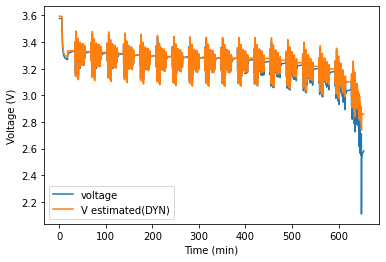

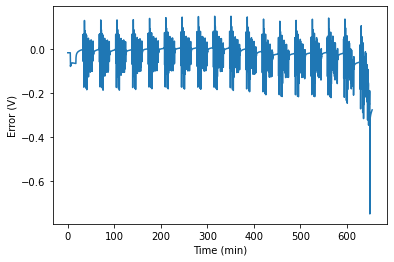

NameError: name 'OCVfromSOCtemp' is not defined

In [64]:
i = 3

temp_str = mag_list[i]

data = d[temp_str]

# Measured Current
ik = data['S1']['current']

# Measured Voltage
vk = data['S1']['voltage']

# Time of measurement
tk = np.arange(len(ik))

# Cell Capacity
Q = out_d[temp_str]['Q']

# Charging Efficiency
eta = out_d[temp_str]['eta']

# eta_ik calculation
# Only used for time when battery was charging
etaik = ik
etaik[ik < 0] = etaik[ik < 0]*eta
        
# ================== Error with OCV calculation ==================

# OCV from coloumb counting formula is used
v_coloumb = out_d[temp_str]['ocv']
verr = vk - v_coloumb

# Y = AX
Y = -np.diff(verr)
X = np.diff(etaik)
A = SISOsubid(Y,X,numpoles)

# Modify results to ensure real, preferably distinct, between 0 and 1

eigA = np.linalg.eigvals(A)
eigAr = eigA + 0.001 * np.random.normal(loc=0.0, scale=1.0, size=eigA.shape)
eigA[eigA != np.conj(eigA)] = abs(eigAr[eigA != np.conj(eigA)]) # Make sure real
eigA = np.real(eigA)                                            # Make sure real
eigA[eigA<0] = abs(eigA[eigA<0])    # Make sure in range 
eigA[eigA>1] = 1 / eigA[eigA>1]
RCfact = np.sort(eigA)
RCfact = RCfact[-numpoles:]
RC = -1 / np.log(RCfact)

# Simulate the R-C filters to find R-C currents
stsp = dlti(np.diag(RCfact), np.vstack(1-RCfact), np.eye(numpoles), np.zeros((numpoles, 1))) 
[tout, vrcRaw, xout] = dlsim(stsp, etaik)


# ================== Hysterisis Calculation ================== 

# Hysterisis Voltage
hh = 0*ik

# Current Sign Change
sik = 0*ik

# Hysterisis Factor
fac = np.exp(-abs(gamma*etaik/(3600*Q)))

for k in range(1,len(ik)):
    
    hh[k] = fac[k-1]*hh[k-1] + (1-fac[k-1])*np.sign(ik[k-1])

    sik[k] = np.sign(ik[k])
    if abs(ik[k]) < Q/100:
        sik[k] = sik[k-1]
        
if doHyst:
    H = np.column_stack((hh, sik, -etaik, -vrcRaw))
    W = nnls(H, verr)
    M = W[0][0]
    M0 = W[0][1]
    R0 = W[0][2]
    Rfact = W[0][3:].T
    
else:
    H = np.column_stack((-etaik, -vrcRaw))
    W = np.linalg.lstsq(H,verr, rcond=None)[0]
    M = 0
    M0 = 0
    R0 = W[0]
    Rfact = W[1:].T
    
    
v_est = v_coloumb + M*hh + M0*sik - R0*etaik - vrcRaw @ Rfact.T 
verr = vk - v_est

# Voltage plots

plt.figure(1)
plt.plot(tk[::10]/60, vk[::10], label='voltage')
# plt.plot(tk[::10]/60, v_coloumb[::10], label='vest1 (OCV)')
plt.plot(tk[::10]/60, v_est[::10], label='V estimated(DYN)')
plt.xlabel('Time (min)')
plt.ylabel('Voltage (V)')
plt.legend(loc='best', numpoints=1)
plt.show()

# Modelling Error

plt.figure(2)
plt.plot(tk[::10]/60, v_err[::10], label='verr')
plt.xlabel('Time (min)')
plt.ylabel('Error (V)')
plt.show()

# Compute RMS error only on data roughly in 5% to 95% SOC

v1 = OCVfromSOCtemp(0.95, data[ind].temp, model)[0]
v2 = OCVfromSOCtemp(0.05, data[ind].temp, model)[0]
N1 = np.where(vk < v1)[0][0]
N2 = np.where(vk < v2)[0][0]

rmserr = np.sqrt(np.mean(verr[N1:N2]**2))
cost = np.sum(rmserr)
print(f'RMS error = {cost*1000:.2f} mV')










